# 1 Exercise: Digit recognition
# This exercise is mandatory for all the students

Given the following 'mnist' dataset and the matrices with the test and the training  as below:

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
f = open("mnist_test_10.csv", 'r')
m_test = f.readlines()
f.close()

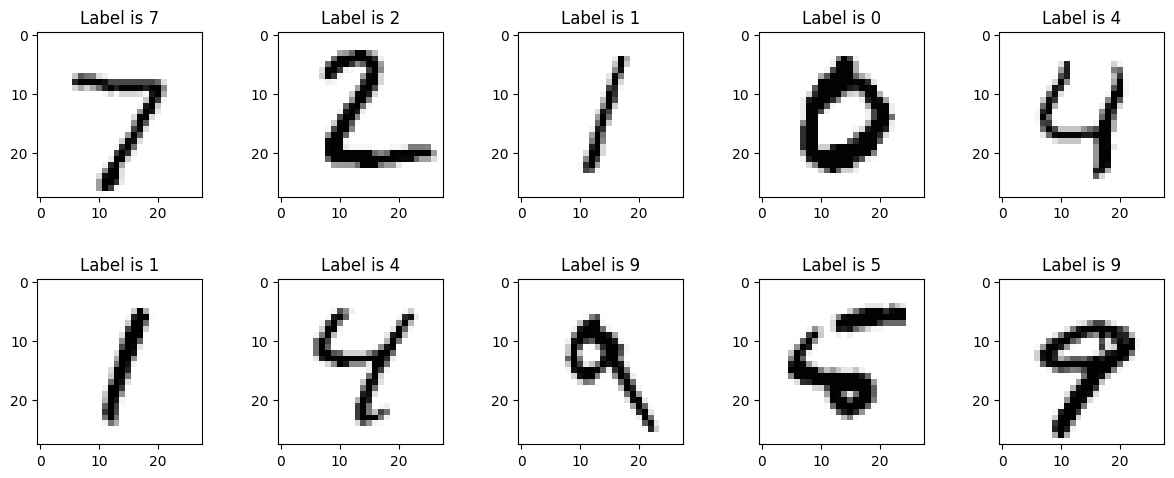

In [3]:
fig = plt.figure(figsize=(15,15))
count=1
ncol_img = 28
nrow_img = 28
col_test = len(m_test)
row_test= ncol_img*nrow_img
test_array = np.zeros((row_test,col_test))
test_lab = np.zeros((col_test,1))
ik=0
for line in m_test:
    lab_img = line.split(',')
    imarray = np.asfarray(lab_img[1:]).reshape((ncol_img,nrow_img))
    test_array[:,ik] = imarray.reshape(row_test)
    test_lab[ik] = np.asarray(lab_img[0])
    ik = ik+1
    plt.subplot(5,5,count)
    plt.subplots_adjust(hspace=0.5)
    count += 1
    plt.title("Label is " + lab_img[0])
    plt.imshow(imarray, cmap='Greys', interpolation='None')
    pass

In [4]:
f = open("mnist_train_100.csv", 'r')
m_train = f.readlines()
f.close()

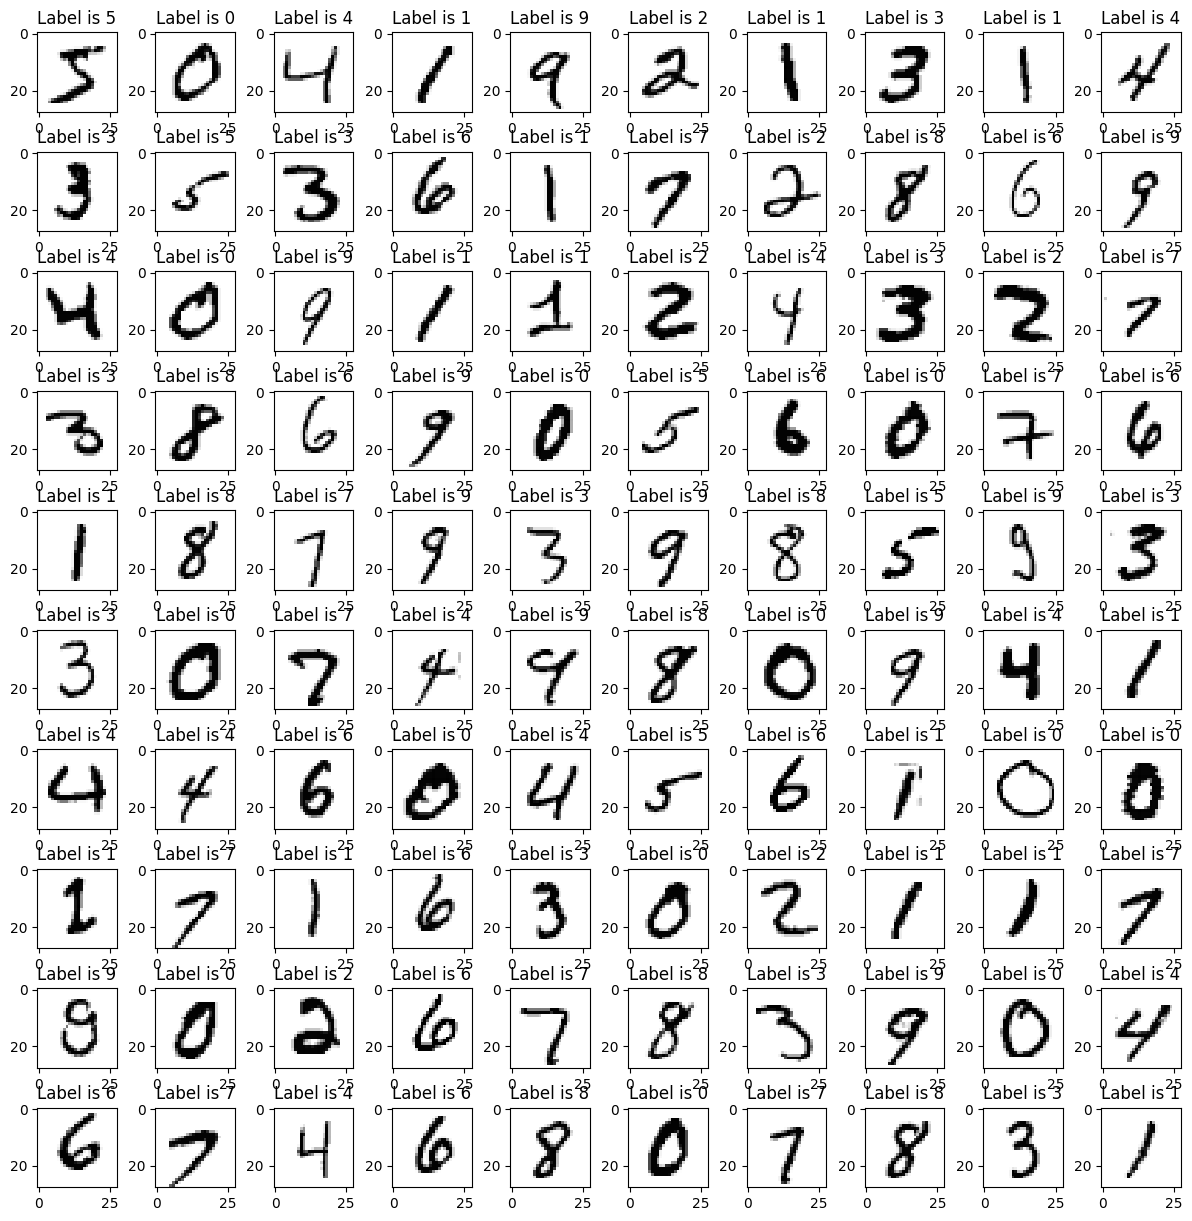

In [5]:
# Compute the matrix with the train set
fig = plt.figure(figsize=(15,15))
count=1
ncol_img = 28
nrow_img = 28
col_train = len(m_train)
row_train= ncol_img*nrow_img
train_array = np.zeros( (row_train,col_train) )
train_lab = np.zeros((col_train,1))
ik = 0
for line in m_train:
    lab_img = line.split(',')
    imarray = np.asfarray(lab_img[1:]).reshape((28,28))
    train_array[:,ik] = imarray.reshape(row_train)
    train_lab[ik] = np.asarray(lab_img[0])
    ik = ik+1
    plt.subplot(10,10,count)
    plt.subplots_adjust(hspace=0.5)
    count += 1
    plt.title("Label is " + lab_img[0])
    plt.imshow(imarray, cmap='Greys', interpolation='None')
    pass

Check the size of the training and test dataset, as well as, the number of images for each class (both for training and test.

In [6]:
def bar_plot_count_samples(data_label):
    unique_values, counts = np.unique(data_label, return_counts=True)
    plt.bar(unique_values, counts)
    plt.xticks(range(0,10))
    plt.xlabel('Class label')
    plt.ylabel('Number of samples')
    plt.show()

test_array shape: (784, 10)
test_lab shape: (10, 1)


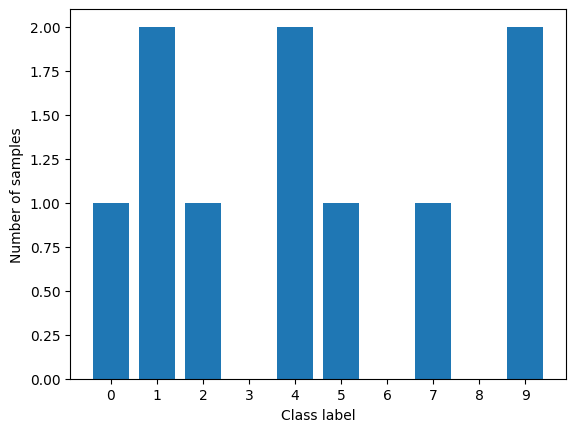

In [7]:
n_row_test, n_col_test = test_array.shape
print(f'test_array shape: {test_array.shape}')
print(f'test_lab shape: {test_lab.shape}')
bar_plot_count_samples(test_lab)

train_array shape: (784, 100)
train_lab shape: (100, 1)


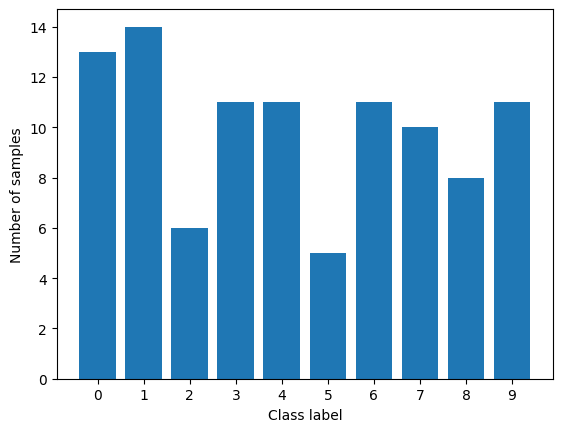

In [8]:
n_row_train, n_col_train = train_array.shape
print(f'train_array shape: {train_array.shape}')
print(f'train_lab shape: {train_lab.shape}')
bar_plot_count_samples(train_lab)

- Compute the mean image and subtract it from all the other images. Perform the PCA of the resulting matrix. For each digit in the training-set compute its class, that is the mean of the coordinates of the projection in the orthogonal column space defined by the PCA factorization. Determine to which class every digit of the test-set belongs to by computing the minimal two norm distance.

- Check and compare all the studied techniques to find the minimal value of $k$, number of principal components that are useful to classify the digit.

- Classify all the digit in the testset and compute the confusion matrix. That is the matrix where, for each face i, the element of index i,j contains the number of observations known to be in group i and predicted to be in group j. Use sklearn.metrics.confusion_matrix and compute also  the classification report using ``sklearn.metrics.classification_report``.

Since we want to perform the PCA, we need to compute the mean image on the training set and subtract it to all the images in the training set.

- ``mean_train_array`` is a vector of size (784,)
- ``e`` is a vector of size (1,100)
- ``np.dot(mean_train_array.reshape(n_row_train,1),e)`` first reshape ``mean_train_array`` in (784,1), then we can compute the product between (784,1) and (1,100).
- In the end, we have two matrix of size (784,100) and we can compute the subtraction.

In [9]:
mean_train_array = np.sum(train_array,axis=1)/n_col_train
print(f'mean_train_array shape: {mean_train_array.shape}')

e = np.ones((1,n_col_train))
print(f'e shape: {e.shape}')
train_array_no_mean = train_array-np.dot(mean_train_array.reshape(n_row_train,1),e)

mean_train_array shape: (784,)
e shape: (1, 100)


Now, we would like to compare all the studied techniques to find the minimal value of $k$, number of principal components that are useful to classify the digit.

---
We have different criteria to identify the $k$ principal components to retain:
1) Screen plot
2) Cumulative percentage of total variance 
3) Kaiser rule
4) Entropy
5) Relative error in the approximation of the matrix

In [10]:
def screen_plot(sing_val, plot_title, 
                compute_squared_sing_val=False, plot_semilogy = False):
    if compute_squared_sing_val:
        sing_val = sing_val**2.
        
    if plot_semilogy:
        plt.semilogy(sing_val, 'o-')
    else:
        plt.plot(sing_val, 'o-')
    plt.title(plot_title)
    plt.xlabel('k')
    plt.ylabel('singular values')

def cum_perc_tot_variance(sing_val, var_to_account, compute_squared_sing_val=False,
                          plot_results=False, plot_semilogy = False):
    if compute_squared_sing_val:
        sing_val = sing_val**2.
    
    norm_squared_sing_val = sing_val/np.sum(sing_val)
    cum_var = np.cumsum(norm_squared_sing_val)
    k = np.argmax(cum_var>var_to_account)+1
    cum_perc = cum_var*100
    
    if plot_results:
        fig, ax1 = plt.subplots(figsize=(16,5))
        ax1.bar(range(1, len(sing_val) + 1), sing_val, label='Variance')
        if plot_semilogy:
            ax1.set_yscale('log')    
        
        ax2 = ax1.twinx()
        ax2.plot(range(1, len(cum_perc) + 1), cum_perc, color='green', marker='o', label='Cumulative %')
        ax2.axhline(y=(var_to_account*100), color='red', linestyle='--', label='Variance to account')

        ax1.set_xlabel('k')
        ax1.set_ylabel('Variance')
        ax2.set_ylabel('Cumulative percentage of total variance')
        ax2.legend()
        plt.title('Pareto Chart of Variance')

    return k

def kaiser_rule(sing_val, compute_squared_sing_val= False, 
                plot_results=False, plot_semilogy = False):
    if compute_squared_sing_val:
        sing_val = sing_val**2.
        
    mean_sigma = np.mean(sing_val)
    k = np.sum(sing_val > mean_sigma)
    
    if plot_results:
        plt.figure(figsize=(16,5))
        plt.bar(range(1,len(sing_val)+1), sing_val, label='Explained variance')
        plt.axhline(y=mean_sigma, color='red', linestyle='--', label='Mean variance')
        if plot_semilogy:
            plt.yscale('log')
        plt.xlabel('k')
        plt.ylabel('singular values')
        plt.title('Kaiser Rule')
        plt.legend()
    
    return k

def entropy(sing_val, tol=None, compute_squared_sing_val=False): 
    if compute_squared_sing_val:
        sing_val=sing_val**2.
    
    fk = sing_val/ np.sum(sing_val)
    r = len(sing_val) # number of singular values
    entr = (-1/np.log(r))*np.sum(fk*np.log(fk))
    ks = r*entr
    ks = int(ks)
    
    if tol is not None:
        ks=[]
        for ind in tol:
            perc=1-ind
            t = r*entr*perc
            ks.append(int(t))
    return ks

def low_rank_matrix_approximation(sing_val, tol, compute_squared_sing_val=False):
    if compute_squared_sing_val:
        sing_val=sing_val**2.
    
    k = []
    for ind in tol:
        k.append(np.sum(abs(sing_val)/max(abs(sing_val)) >= ind))
    return k

In order to find the proper number of $k$ principal component, we compute the PCA with all the directions and we compare the studied method to select the proper number of components.

- Screen plot suggests a number of components equal to 9.
- Cumulative percentage of total variance suggests a number of 
  components equal to 25 to account at least a cumulative variance > 80.0%.
- Kaiser rule suggests a number of components equal to 24.
- Entropy rule with tolerance [0.1, 0.05, 0.01, 0.005, 0.001, 1e-05, 1e-08]
  suggests a number of components equal to [70, 74, 77, 78, 78, 78, 78].
- Low rank matrix approximation rule with tolerance [0.1, 0.05, 0.01, 0.005, 0.001, 1e-05, 1e-08]
  suggest a number of components equal to [21, 33, 73, 89, 99, 99, 99].


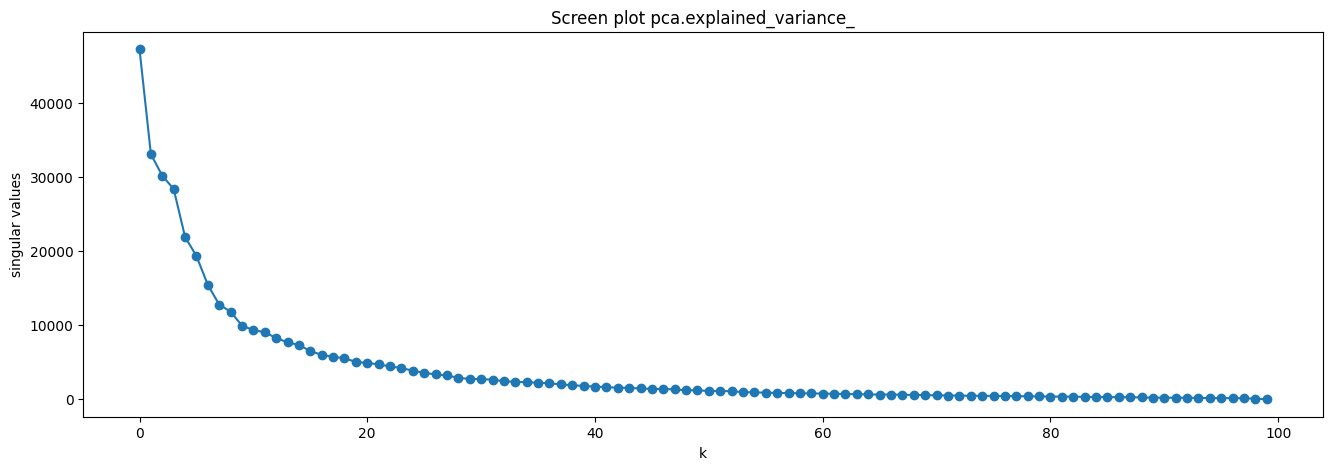

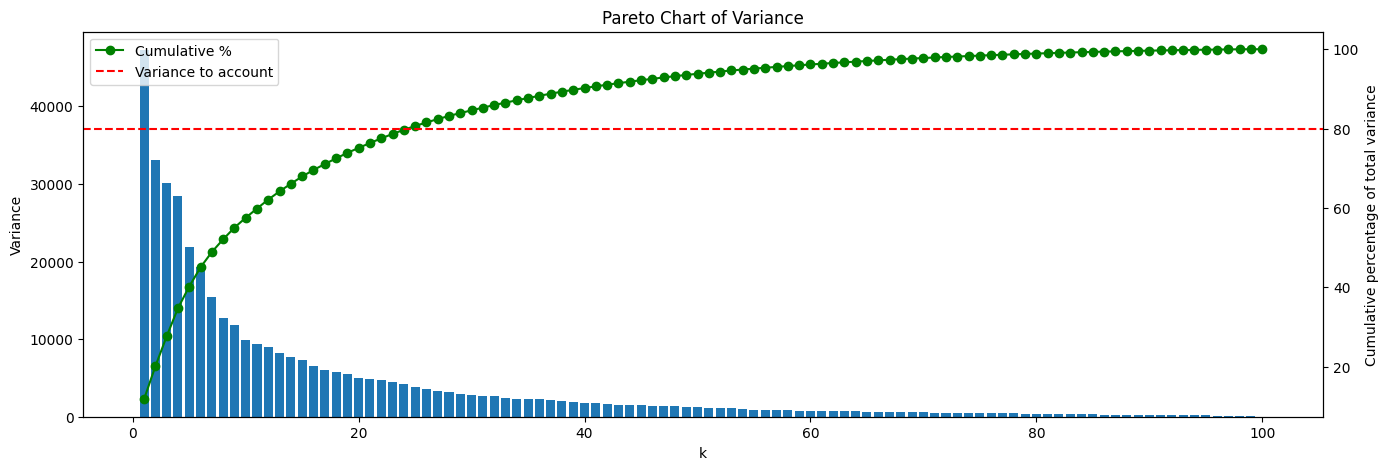

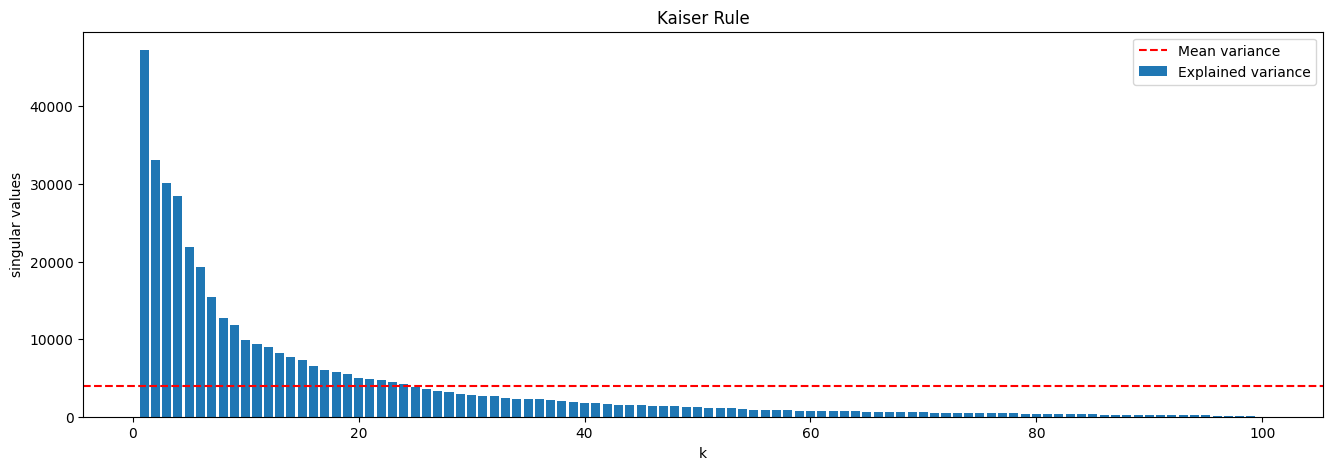

In [11]:
pca = PCA(copy=True, whiten=True).fit(train_array_no_mean)
tol=[1e-1,5e-2,1e-2,5e-3,1e-3,1e-5,1e-8] 

# Screen plot
plt.figure(figsize=(16, 5))
screen_plot(pca.explained_variance_, plot_title='Screen plot pca.explained_variance_', 
            compute_squared_sing_val=False, plot_semilogy=False)
print(f'- Screen plot suggests a number of components equal to 9.')

# Cumulative percentage total variance
threshold=0.80
k = cum_perc_tot_variance(pca.explained_variance_, var_to_account=threshold,
                          compute_squared_sing_val=False, plot_results=True,
                          plot_semilogy = False)
print(f'- Cumulative percentage of total variance suggests a number of \n'
      f'  components equal to {k} to account at least a cumulative variance > {threshold*100}%.')

# Kaiser rule
k=kaiser_rule(pca.explained_variance_, compute_squared_sing_val= False, 
            plot_results=True, plot_semilogy = False)
print(f'- Kaiser rule suggests a number of components equal to {k}.')

# Entropy
k = entropy(pca.explained_variance_, tol=tol, compute_squared_sing_val=False)
print(f'- Entropy rule with tolerance {tol}\n'
      f'  suggests a number of components equal to {k}.')

# Low-rank matrix approximation
k = low_rank_matrix_approximation(pca.explained_variance_, 
                                  tol=tol, compute_squared_sing_val=False)
print(f'- Low rank matrix approximation rule with tolerance {tol}\n'
      f'  suggest a number of components equal to {k}.\n')

From the previous comparison, we have some hint on the number of $k$ components that should be retained. The screen plot seems to show the characteristic elbow at $k=9$. Then, using Keiser rule, we can identify $k=24$, that is the number of components with variance greater than the mean variance. At the same time, fixing a threshold of 80%, we need $k=25$ components to account for at least that cumulative total variance. Lastly, fixing different tolerance, we compute entropy and low-rank approximation, and we obtain different possible number of components $k$. In the end, we select $k=24$ since two methods give us quite similar results. In fact, with Keiser rule, we know that we take only the components with variance greater than the mean variance. From the cumulative percentage of total variance we also know that with $k=25$ we account for the 80% of total variance. So fixing $k=24$ ensures that we take only the components with variance greater than the mean variance, accounting at the same time about 80% of total variance.

---


In reality, searching empirically $k$ between 9 and 20 reveals that 15 components are enough to reach the same model accuracy reached with 24 components. 

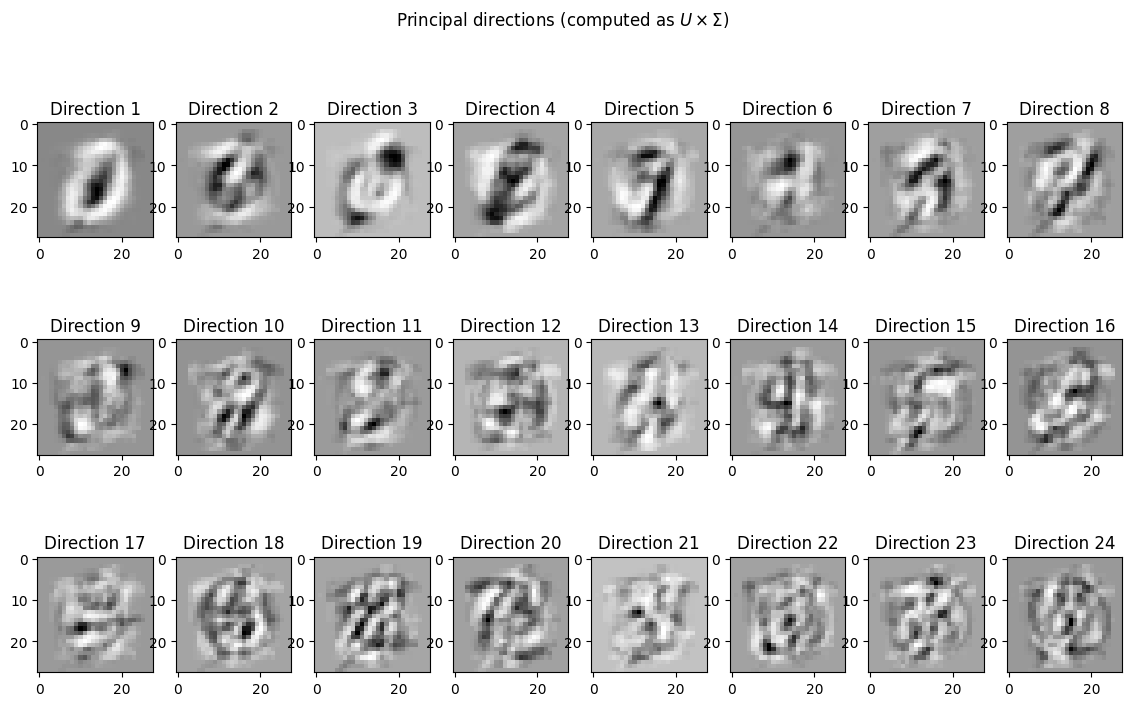

In [12]:
k = 24
pca = PCA(copy=True, n_components=k, whiten=True).fit(train_array_no_mean)
train_array_pca = pca.transform(train_array_no_mean) # Columns of matrix U * sigma  
#train_array_pca = train_array_pca/np.sqrt(n_row_train) # to make sure that columns are othogonal

plt.figure(figsize=(14,8))
plt.suptitle("Principal directions (computed as $U \\times \Sigma$)")
for i in range(0,k):
    plt.subplot(3,8,i+1)
    plt.imshow(train_array_pca[:,i].reshape(nrow_img,ncol_img),
               cmap='Greys',interpolation='None') 
    plt.title('Direction '+str(i+1))

Now, for each digit in the training-set compute its class, that is the mean of the coordinates of the projection in the orthogonal column space defined by the PCA factorization. So, firstly, for each image we compute the coordinates; then, for each digit, we compute the mean of the coordinates of all the images related to that digit. 


In [13]:
# coord_project_train is a dictionary; 
# each element of the dictionary represents a digit;
# each element collects the coordinates of the projection.
# in this way, we have all together the coordinates of the projection of the same images.
coord_project_train = {}
for i in range(0,10):
    coord_project_train[i]=[]

j = 0
while j < n_col_train:
    # subtract the mean computed on all the training images
    proj_train_im_j = train_array[:, j] - mean_train_array

    # subtract the mean of that specific image
    proj_train_im_j = proj_train_im_j - np.mean(proj_train_im_j)

    # compute the coordinates of the projection
    proj_train_im_j = np.dot(train_array_pca.T, proj_train_im_j)

    index_train_label = train_lab[j,0]
    coord_project_train[index_train_label].append(np.array(proj_train_im_j))

    j = j + 1

For each class, we compute the mean of all coordinates related to that class.

In [14]:
mean_coord_project_train = {}
for i in range(0,10):
    mean_coord_project_train[i]=np.mean(coord_project_train[i], axis=0) 

Now, we would like to compute the coordinates of the projection of each image in the test set.

In [15]:
coord_proj_test = []
for i in range(0,n_col_test):
    # subtract the mean of the training data
    proj_test_im_i=test_array[:,i]-mean_train_array 
    
    # subtract the mean of that specific image
    proj_test_im_i=proj_test_im_i-np.mean(proj_test_im_i)
    
    # these are the coefficients of the projection, not the projection
    coord_proj_test.append(np.dot(train_array_pca.T, proj_test_im_i)) #(Ua.T * q)     

Finally, we can determine to which class every digit of the test-set belongs to by computing the minimal two norm distance.

In [16]:
err_2norm = np.zeros((10,1))
pred_test_lab = np.zeros((n_col_test,1))
for j in range(0, n_col_test): # for each test image
    for i in range(0,10): # compare in two norm the test image with the mean_coord_project_train
        err_2norm[i]= np.linalg.norm(mean_coord_project_train[i] - coord_proj_test[j])
    
    # minimal error in 2-norm give us the class for that test image
    pred_test_lab[j]=np.argmin(err_2norm)

In the end, we show the classification performance on test set using both the confusion matrix and the classification report.

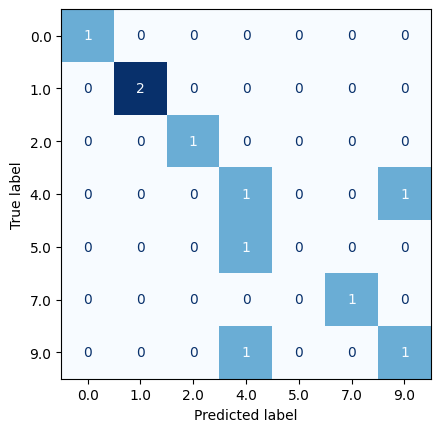

In [17]:
cf=confusion_matrix(test_lab, pred_test_lab)
d=ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=[0., 1., 2., 4., 5., 7., 9.])
d.plot(cmap='Blues', values_format='d', colorbar=None)

In [18]:
print(classification_report(test_lab,pred_test_lab))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         2
         2.0       1.00      1.00      1.00         1
         4.0       0.33      0.50      0.40         2
         5.0       0.00      0.00      0.00         1
         7.0       1.00      1.00      1.00         1
         9.0       0.50      0.50      0.50         2

    accuracy                           0.70        10
   macro avg       0.69      0.71      0.70        10
weighted avg       0.67      0.70      0.68        10


D:\2_UNIVERSITA\2_MAGISTRALE\1_ANNO\2_NUM_METHODS_FOR_CS\Code-Ex\Py-Ex\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\2_UNIVERSITA\2_MAGISTRALE\1_ANNO\2_NUM_METHODS_FOR_CS\Code-Ex\Py-Ex\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\2_UNIVERSITA\2_MAGISTRALE\1_ANNO\2_NUM_METHODS_FOR_CS\Code-Ex\Py-Ex\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

# 2  Exercise: Spectral clustering

## This exercise is meant for students attending the course of the accademic year 2023-2024.

Import the following:

In [19]:
from sklearn import datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sla

Construct a dataset consisting of two non-convex half-circles by using the codes below:

In [20]:
n_samples = 500
seed = 1
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)

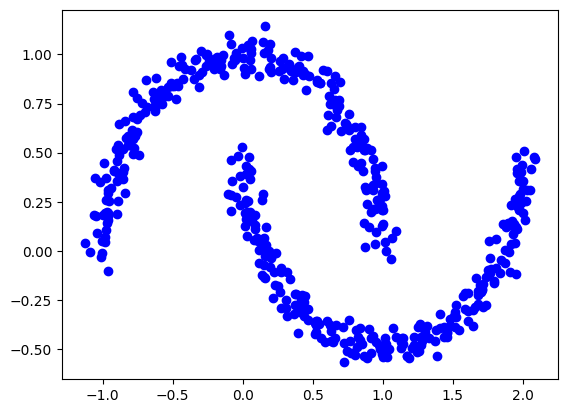

In [21]:
x_p = noisy_moons[0][:,0]
y_p = noisy_moons[0][:,1]

plt.figure()
plt.plot(x_p,y_p, 'ob')

- Construct a similarity-matrix ``C`` by using the nearest-neighbors distance with the command below:

In [22]:
C = kneighbors_graph(noisy_moons[0], n_neighbors=5, include_self=False)

This method returns a ``sparse`` matrix object. Hence, to operate with it with the standard methods, it is necessary to convert it to a ``numpy array`` object with:

``C = C.toarray()``

In [23]:
C = C.toarray()
print(f'- The shape of the matrix C is {C.shape}')
print(f'- C is a symmetric matrix? {sla.issymmetric(C)}')

- The shape of the matrix C is (500, 500)
- C is a symmetric matrix? False


Make the matrix ``C`` symmetric:
$$
C = \frac{1}{2}(C + C^\top)
$$

In [24]:
C = 1/2*(C+C.T)
print(f'C is a symmetric matrix? {sla.issymmetric(C)}')

C is a symmetric matrix? True


- Make an affinity matrix $A$:
$$
A = e^{-C^2}
$$

In [25]:
A = np.exp(-C**2)
print(f'The shape of the matrix A is {A.shape}')

The shape of the matrix A is (500, 500)


- Compute the SVD of the affinity matrix $A$: ``[U,S,V] = np.linalg.svd(A)``. The matrix $A$ will have size $n\times n$.


---

``[U,S,V] = np.linalg.svd(A)`` returns the matrix $U$ (left singular vectors), the vector $S$ with the singular values and the matrix $V^T$ (right singular vectors). The singular values in vector $S$ are ordered such that $\sigma_1 \geq \sigma_2 \geq ... \sigma_r > 0$.

In [26]:
[U, S, V] = np.linalg.svd(A)
print(f'Shape of U: {U.shape}\nShape of S: {S.shape}\nShape of V^T: {V.shape}')

Shape of U: (500, 500)
Shape of S: (500,)
Shape of V^T: (500, 500)


- Plot in a semilogaritmic scale the singular values of the inverse matrix $A^{-1}$ (Note: Do NOT compute the inverse $A^{-1}$ but use what the theory says!!!) 
- We know that the smallest singular values of $A$ "somehow" correspond to the biggest singular values of $A^{-1}$, therefore, apply the known criteria to the singular values of $A^{-1}$. For this example, we know that the exact number of components to retain should be 2. Therefore, analyse the studied criteria and identify which one is the more correct one for this task. 

---

From the theory, we know that if A is non singular, then the SVD of A is $A=U_{n \times n} \Sigma_{n \times n} V^T_{n \times n}$. 

Since $A$ is non singular, exists $A^{-1}$ such that $A^{-1} = (U \Sigma V^T)^{-1}$.

From the reverse order low we know that 

$A^{-1} = (U \Sigma V^T)^{-1} = (V^T)^{-1} \Sigma^{-1} U^{-1}$

and from the orthogonality of U and V, for which $U^T = U^{-1}$, since $UU^T = U^TU = I$ (same for $V$)


$= (V^T)^T \Sigma^{-1} U^T = V \Sigma^{-1} U^T$

where $\Sigma^{-1} = diag(\sigma_1^{-1}, \sigma_2^{-1}, ... \sigma_n^{-1})$

Since we know that $\sigma_1 \geq \sigma_2 \geq \sigma_n$ then $\sigma_1^{-1} \leq \sigma_2^{-1} \leq \sigma_n^{-1}$.

So, we can obtain the singular values of $A^{-1}$ just computing the reciprocal of the singular values of $A$.

What we obtain is not exactly the SVD of the matrix $A^{-1}$ since the singular values of $\Sigma^{-1}$ are not sorted from the biggest to the smallest, but from the smallest to the biggest. In order to obtain exactly the SVD of the matrix $A^{-1}$ we should perform columns and rows permutations.

- Screen plot suggests a number of components equal to 2.
- Cumulative percentage of total variance suggests a number of 
  components equal to 2 to account at least a cumulative variance > 75.0%.
- Kaiser rule suggests a number of components equal to 16.
- Entropy rule with tolerance [0.1, 0.05, 0.01, 0.005, 0.001, 1e-05, 1e-08]
  suggests a number of components equal to [113, 119, 124, 125, 125, 125, 125].
- Low-rank matrix approximation rule with tolerance [0.1, 0.05, 0.01, 0.005, 0.001, 1e-05, 1e-08]
  suggest a number of components equal to [2, 5, 9, 14, 24, 341, 499].


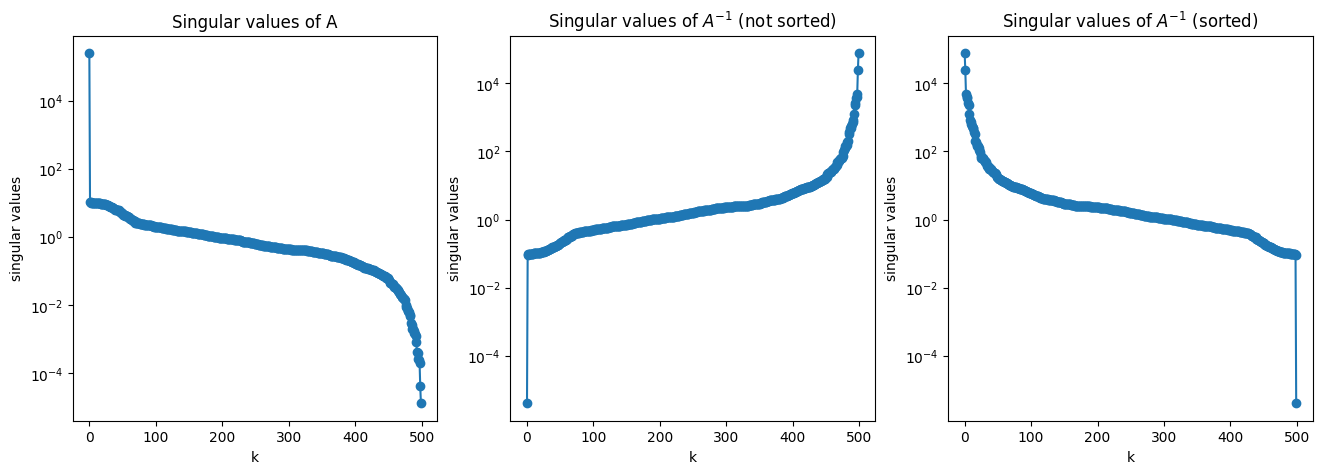

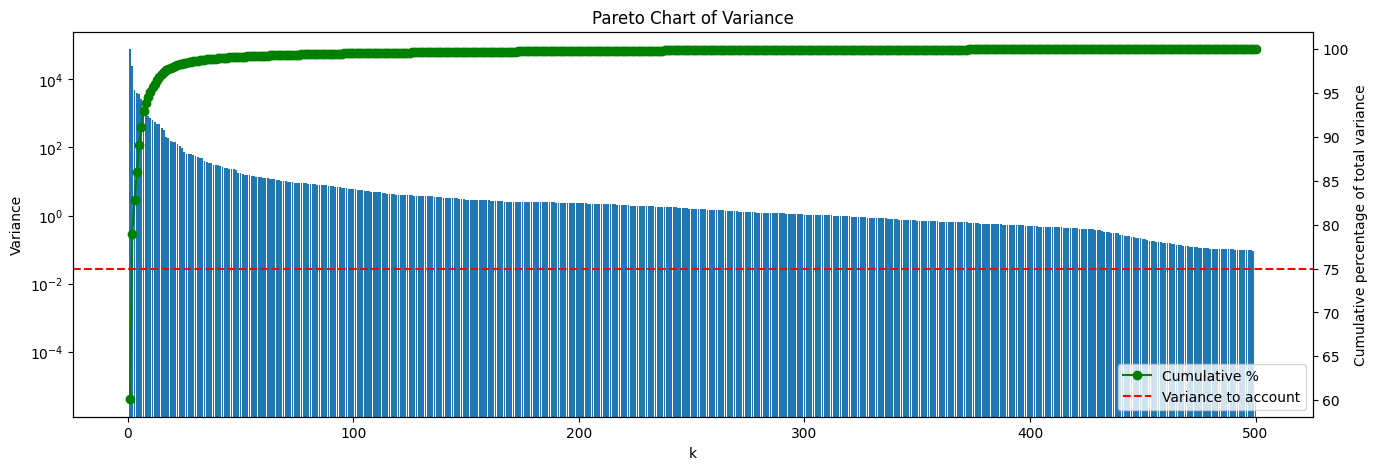

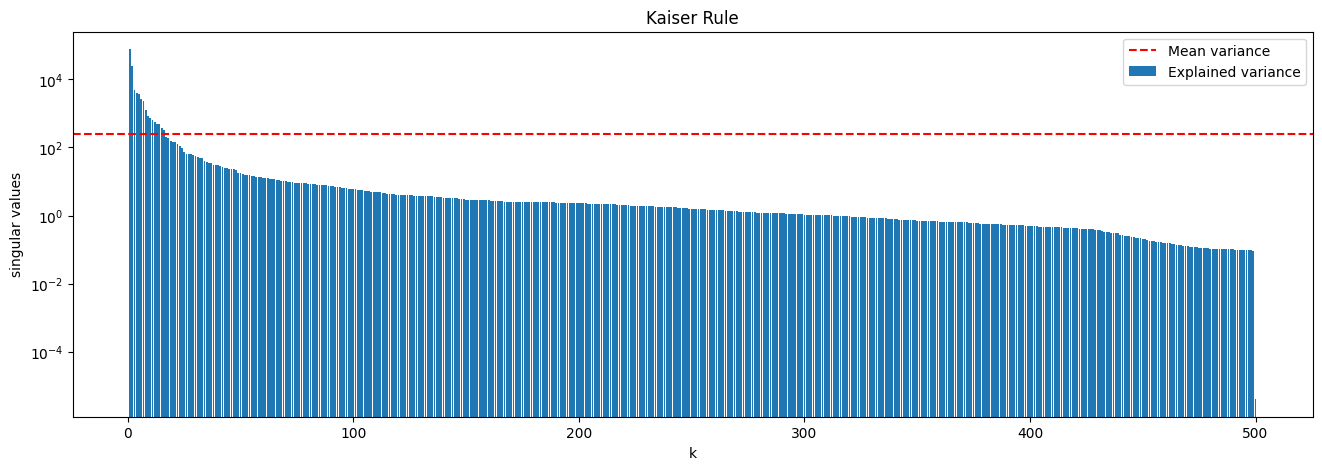

In [27]:
S_inv_not_sort = 1./S
S_inv = S_inv_not_sort[::-1] #reorder the singular values of A-1 from biggest to lowest

tol=[1e-1,5e-2,1e-2,5e-3,1e-3,1e-5,1e-8]

# Screen plot
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
screen_plot(S,plot_title='Singular values of A', 
            compute_squared_sing_val=True, plot_semilogy=True)
plt.subplot(1,3,2)
screen_plot(S_inv_not_sort,plot_title='Singular values of $A^{-1}$ (not sorted)', 
            compute_squared_sing_val=True, plot_semilogy=True)
plt.subplot(1,3,3)
screen_plot(S_inv,plot_title='Singular values of $A^{-1}$ (sorted)', 
            compute_squared_sing_val=True, plot_semilogy=True)
print(f'- Screen plot suggests a number of components equal to 2.')

# Cumulative percentage total variance
threshold = 0.75
k = cum_perc_tot_variance(S_inv, threshold, 
                          compute_squared_sing_val=True, 
                          plot_results=True, 
                          plot_semilogy=True)
print(f'- Cumulative percentage of total variance suggests a number of \n'
      f'  components equal to {k} to account at least a cumulative variance > {threshold*100}%.')

# Kaiser rule
k = kaiser_rule(S_inv, compute_squared_sing_val=True,
                plot_results=True, plot_semilogy=True)
print(f'- Kaiser rule suggests a number of components equal to {k}.')

# Entropy
k = entropy(S_inv,compute_squared_sing_val=True, tol=tol)
print(f'- Entropy rule with tolerance {tol}\n'
      f'  suggests a number of components equal to {k}.')

# Low-rank matrix approximation
k = low_rank_matrix_approximation(S_inv, tol=tol, compute_squared_sing_val=True)
print(f'- Low-rank matrix approximation rule with tolerance {tol}\n'
      f'  suggest a number of components equal to {k}.')

We already know that for this task we need only two components (since we have two semicircles to clusterize). For the spectral clustering, we should identify the number of eigenvalues equal to zero (in practice, lower than a threshold) which tell us the proper number of clusters.

The screen plot helps us to easily identify the nature of the singular values. Thus, we can see that there are two smallest singular values. Then, from the pareto chart, we can see that to retain at least the 75% ot total variance, we need to consider at least two components; thus, this technique should work well in the identification of the number of clusters. Lastly, the low-rank matrix approximation with a tolerance set to $0.1$ identifies exactly two components to take into account. For all the other tolerance, fails to identify the correct number of clusters. Moreover, all the other techniques, meaning the Kaiser rule and the entropy role, lead to a greater number of components, that are useless for this type of task. 


- Construct the Laplace matrix $L$ by using the following instructions:

  -- Construct the degree matrix $D$ such that every diagonal entry is computed as $(D)_{ii} = \displaystyle{\sum_{j=1}^n (A)_{ij}}$
  
  -- Construct the un-normalized Laplacian matrix $L = D-A$. The obtained matrix $L$ should be symmetric. Check that $L$ is symmetric.

In [28]:
D=np.diag(np.sum(A,axis=0)) #axis=0 sum by columns
L=D-A
print(f'L is a symmetric matrix? {sla.issymmetric(L)}')

L is a symmetric matrix? True


- Compute the SVD of the obtained matrix $L$: ``[U_l,S_l,V_l] = np.linalg.svd(L)``
- Apply K-means clustering to the orthogonal 2 vector basis corresponding to the 2 smallest singular values:

``kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(M)``

What is the matrix $M$ in the command above? How can you compute it by using either ``U_l`` or ``V_l``?

The matrix $M$ is the matrix containing the first two orthogonal vectors of the basis of the range of $L$ or the first two orthogonal vectors of the basis of the range of $L^T$. In fact, when we apply the SVD on the matrix L, supposing that the matrix $L$ has $rank(L)=r$, the first r columns of U_l are the vectors of the orthonormal basis of $R(L)$, while the first r columns of V_l are the vectors of the orthonormal basis of $R(L^T)$. Thus, if we compute $M$ using U_l, we are just taking the first two vectors of the orthogonal basis of $R(L)$, while if we compute $M$ using V_l, we are taking the first two vectors of the orthogonal basis of $R(L^T)$. In that case, since the matrix V_l corresponds to $V^T$, we need to transpose and then take the first two columns.



In [29]:
U_l, S_l, V_l = np.linalg.svd(L)
M=V_l.T[:,0:2]
#M=U_l[:,0:2]
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(M)

D:\2_UNIVERSITA\2_MAGISTRALE\1_ANNO\2_NUM_METHODS_FOR_CS\Code-Ex\Py-Ex\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


- Finally plot the obtained result with the command:

``plt.scatter(x_p,y_p,c= kmeans)``

If the exercise is correctly done, you should be able to see two clusters corresponding to the two distinct semicircles.

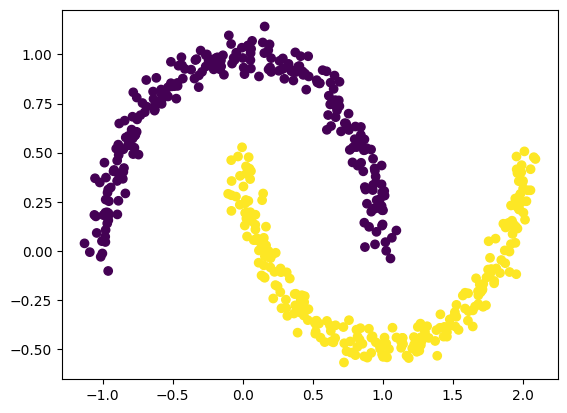

In [30]:
plt.scatter(x_p,y_p,c=kmeans)